# Analyze whole-brain activity

Loaded 4 trials.
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-03-06/Zyla_30min_LHL_27mMhistinj_1pt75pctISO_1/mask_processed_Zyla_30min_LHL_27mMhistinj_1pt75pctISO_1.npy
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-03-06/Zyla_30min_RHL_27mMhistinj_1pt25pctISO_1/mask_processed_Zyla_30min_RHL_27mMhistinj_1pt25pctISO_1.npy
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-02-29/Zyla_30min_RHL_50uL27MMHistinj_wpushbutton_1/mask_processed_Zyla_30min_RHL_50uL27MMHistinj_wpushbutton_1.npy
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-02-29/Zyla_30min_LHL_50uL27MMHistinj_withpushbutton_1/mask_processed_Zyla_30min_LHL_50uL27MMHistinj_withpushbutton_1.npy
Loaded 4 masks.
Loaded 4 traces.
Loaded 4 sync infos.


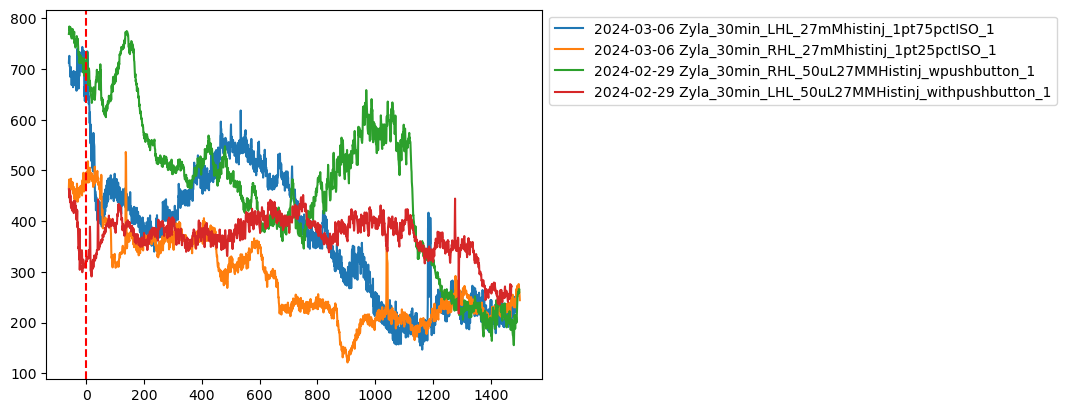

In [30]:
from neuroprocessing.imagingtrials import ImagingTrials
import matplotlib.pyplot as plt
import numpy as np
params = {
        "downsample_factor": 8,
        "aligner_target_num_features": 700,
        "secs_before_stim": 60, # only process frames starting at X seconds before stimulus
        "preprocess_prefix": "aligned_downsampled_",
        "process_prefix": 'processed_',
        "s3fs_toplvl_path": "/Users/ilya_arcadia/arcadia-neuroimaging-pruritogens/Videos",
        "local_toplvl_path": "/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/",
        "load_from_s3": False,
        "save_to_s3": False,
        'crop_px' : 20,
        'bottom_percentile' : 5
        }

trials = ImagingTrials(params)
exp_dates, trial_names = trials.filter_exp_and_trial_dirs(# exp_dir="2024-02-29", 
                                                          limb = ".*HL",
                                                          injection_type=".*istinj*")
masks = trials.load_mask_files()
traces = trials.load_traces()
sync_infos = trials.get_sync_infos()
# Plot the traces

fig, ax = plt.subplots()
for trace, exp_date, trial_name, sync in zip(traces, exp_dates, trial_names, sync_infos):
    #  - sync['stim_onset_frame'] / params['downsample_factor']
    t = (np.arange(0, len(trace))) / (sync['framerate_hz'] / params['downsample_factor']) - params['secs_before_stim']
    ax.plot(t, trace, label=exp_date + ' ' + trial_name)
# legend to the right of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.axvline(x=0, color='r', linestyle='--')

# plot masks
# fig, axs = plt.subplots(ncols=len(masks))
# for ax, mask, exp_date, trial_name in zip(axs, masks, exp_dates, trial_names):
#     ax.imshow(mask, cmap='gray')


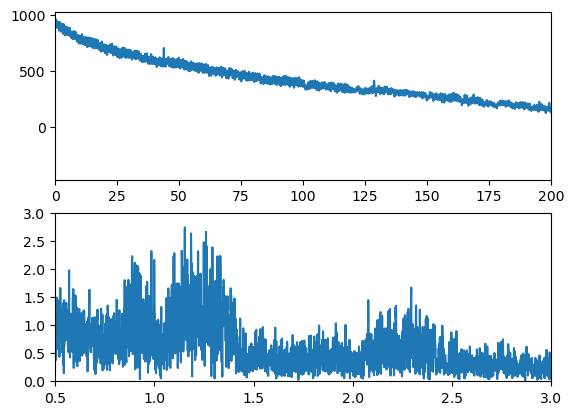

In [65]:
## FFT of the ROI
import numpy as np
import matplotlib.pyplot as plt
# get roi at center of image
center = np.array(img.shape) // 2
roi = img[:,center[1]-50:center[1]+50, center[2]-50:center[2]+50]
roi_mean = np.mean(roi, axis=(1,2))
# calculate heart rate using FFT
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq

fs = 10 # Hz
t_orig = np.arange(0, len(roi_mean)) / fs
roi_mean = roi_mean - np.mean(roi_mean)
N = len(roi_mean)
yf = fft(roi_mean)
yf = 2.0/N * np.abs(yf[0:N//2])

xf = fftfreq(N, 1/fs)[:N//2]
f, axs = plt.subplots(2, 1)
axs[0].plot(roi_mean)
axs[0].set_xlim(0, 200)
axs[1].plot(xf, yf)
plt.xlim(0.5,3)
plt.ylim(0, 3)

# find peaks
peaks, _ = find_peaks(yf, height=5, distance=10)
plt.plot(xf[peaks], yf[peaks], "x")